The following notebook shows how the generator in the GAN can be trained to create
(hopefully) realistic looking digits, i.e. digits from the MNIST database.

Thus the real-samples will simply be drawn from the database, rather than from a
1- or 2-dimensional function.

In [1]:
import random

import torch.nn

from imports import *

We follow the structure in the two preceeding notebooks, and create a "real_function".
But, this time, it loads a random image, rather than computing the output of a given mathematical function

In [2]:
import torchvision

# Load list of MNIST database files
list_of_MNIST_files = list()


In [3]:
mnist_train = torchvision.datasets.MNIST('data', train=True, download=True,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                 (0.1307,), (0.3081,)  # Normalisation factors given before hand
                                             )
                                         ]))

In [4]:
# Set sizes of input and latent space
input_size = torch.flatten(mnist_train[0][0]).shape[0]
n_latent_variables = 10

In [5]:
# generate n real samples with class labels
def generate_real_samples(n):
    x = torch.zeros((n, input_size))
    for sample_idx in range(n):
        img_idx = random.randint(0, len(mnist_train) - 1)
        img = torch.flatten(mnist_train[img_idx][0])
        x[sample_idx, :] = img

    # generate class labels
    y = np.ones((n, 1), dtype=float)
    return x.float(), torch.from_numpy(y).float()


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = 2 * np.random.rand(latent_dim * n) - 1
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)

    return torch.from_numpy(x_input).float()


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n).float()
    # predict outputs
    x = g.forward(x_input).float()
    # create class labels
    y = np.zeros((n, 1), dtype=float)
    y = torch.from_numpy(y).float()
    return x, y


# Summarice the performance,
def summarize_performance(epoch, g, d, latent_dim):
    # prepare real and fake samples
    x_real, y_real = generate_real_samples(4)
    x_fake, y_fake = generate_fake_samples(g, latent_dim, 4)
    # evaluate discriminator on fake examples
    with torch.no_grad():
        y_mreal = d.forward(x_real).reshape(-1)
        y_mfake = d.forward(x_fake).reshape(-1)
    acc_real = 0.0
    acc_fake = 0.0
    for f, r, mf, mr in zip(y_fake, y_real, y_mfake, y_mreal):
        acc_real += 1 if r > .5 and mr > .5 or r < .5 and mr < .5 else 0
        acc_fake += 1 if f > .5 and mf > .5 or f < .5 and mf < .5 else 0
    acc_real /= len(y_fake)
    acc_fake /= len(y_fake)

    # scatter plot real and fake data points
    fig, axs = plt.subplots(2, 4)
    for n in range(4):
        axs[0, n].imshow(np.reshape(x_real[n].detach().numpy(), (28, 28)))
        axs[1, n].imshow(np.reshape(x_fake[n].detach().numpy(), (28, 28)))
    fig.suptitle(' '.join([str(x) for x in [epoch, acc_real, acc_fake]]))
    plt.show()


In [6]:
discriminator = SimpleModel(n_input=input_size,
                            n_hidden=200,
                            n_hidden_layers=2,
                            n_output=1,
                            activation=torch.nn.LeakyReLU(0.2))

generator = SimpleModel(n_input=n_latent_variables,
                        n_hidden=200,
                        n_hidden_layers=2,
                        n_output=input_size,
                        activation=torch.nn.LeakyReLU(0.2))

gan_model = GAN(generator, discriminator)

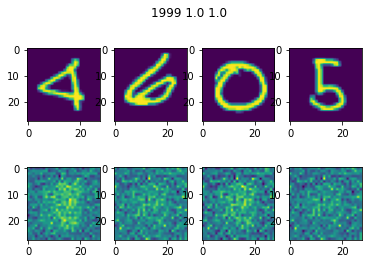

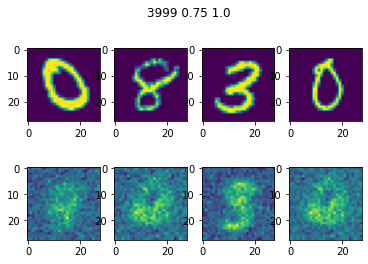

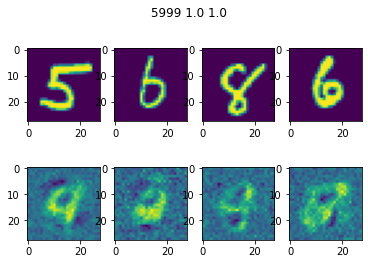

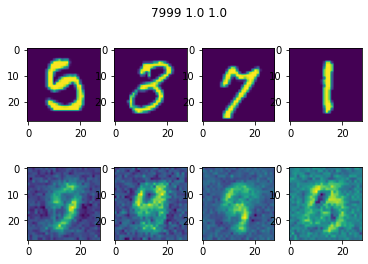

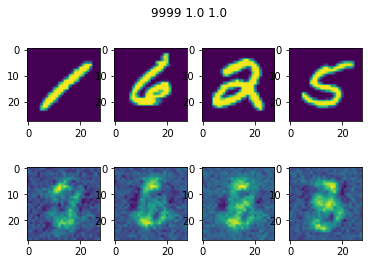

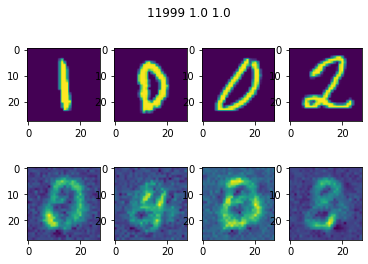

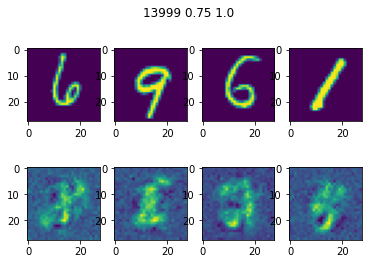

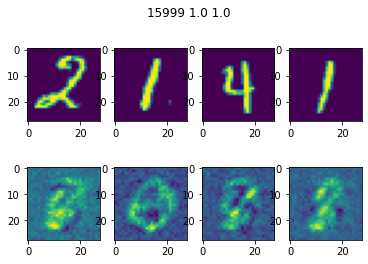

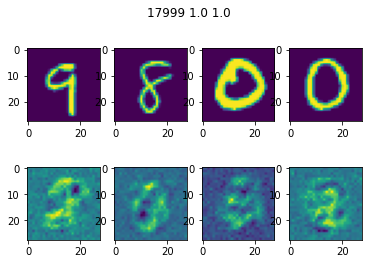

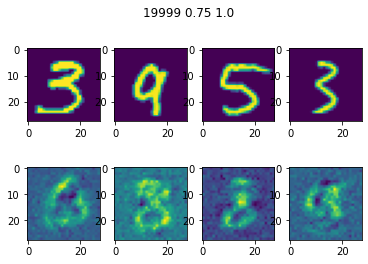

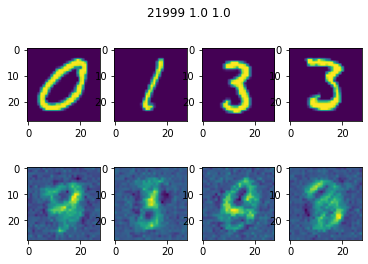

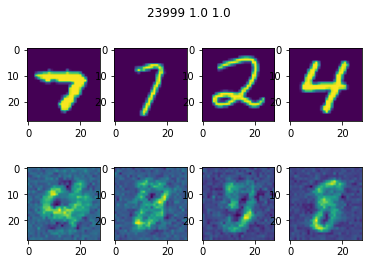

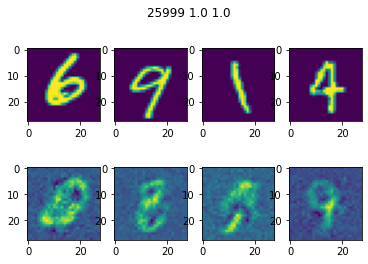

In [ ]:
train_GAN(generator=generator,
          discriminator=discriminator,
          gan_model=gan_model,
          real_generator=generate_real_samples,
          fake_generator=generate_fake_samples,
          latent_generator=generate_latent_points,
          latent_dim=n_latent_variables,
          n_epochs=100000,
          n_eval=10000,
          n_batch=128,
          summarize_func=summarize_performance)